# Combining Hough and Canny Algorithms
## Week 12
The Hough transform is a technique which can be used to isolate features of a particular shape within an image. Because it requires that the desired features be specified in some parametric form, the classical Hough transform is most commonly used for the detection of regular curves such as lines, circles, ellipses, etc. A generalized Hough transform can be employed in applications where a simple analytic description of a feature(s) is not possible. Due to the computational complexity of the generalized Hough algorithm, we restrict the main focus of this discussion to the classical Hough transform. Despite its domain restrictions, the classical Hough transform (hereafter referred to without the classical prefix) retains many applications, as most manufactured parts (and many anatomical parts investigated in medical imagery) contain feature boundaries which can be described by regular curves. The main advantage of the Hough transform technique is that it is tolerant of gaps in feature boundary descriptions and is relatively unaffected by image noise. 

<p align="center"><img src="http://sharky93.github.io/docs/gallery/_images/plot_line_hough_transform_1.png"></p>

---

## Canny Algorithm by John Canny
This paper describes a computational approach to edge detection. The success of the approach depends on the definition of a comprehensive set of goals for the computation of edge points. These goals must be precise enough to delimit the desired behavior of the detector while making minimal assumptions about the form of the solution.
[A Computational Approach to Edge Detection](https://ieeexplore.ieee.org/abstract/document/4767851)

In [28]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2
from math import sqrt, atan2, pi
from PIL import Image, ImageDraw

## M16 Data from NIRCam

In [35]:
hdulist = fits.open("m16_nircam.fits")
hdulist.info()

Filename: m16_nircam.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (738, 465)   float32   


## Visaulization

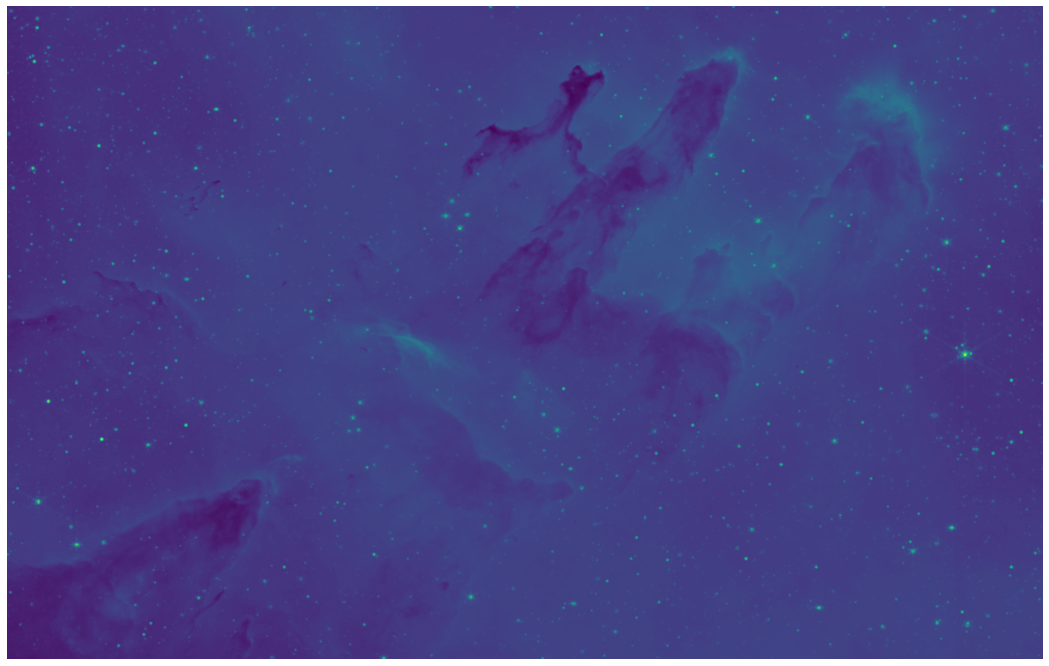

In [36]:
image_data = hdulist[0].data
fig, ax = plt.subplots(figsize=(20, 12))
plt.imshow(image_data, norm=LogNorm(), interpolation='gaussian')
ax.axis('off')
fig.savefig("LogNormInterpolated.png", bbox_inches='tight')
hdulist.close()

## Applying Otsu & Binary Thresholding

In [39]:
# This image was obtained earlier
img = cv2.imread("prof_processed_image.jpg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
filtered = cv2.medianBlur(gray, 1)
binary, threshold = cv2.threshold(filtered, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

<Figure size 1440x1440 with 0 Axes>

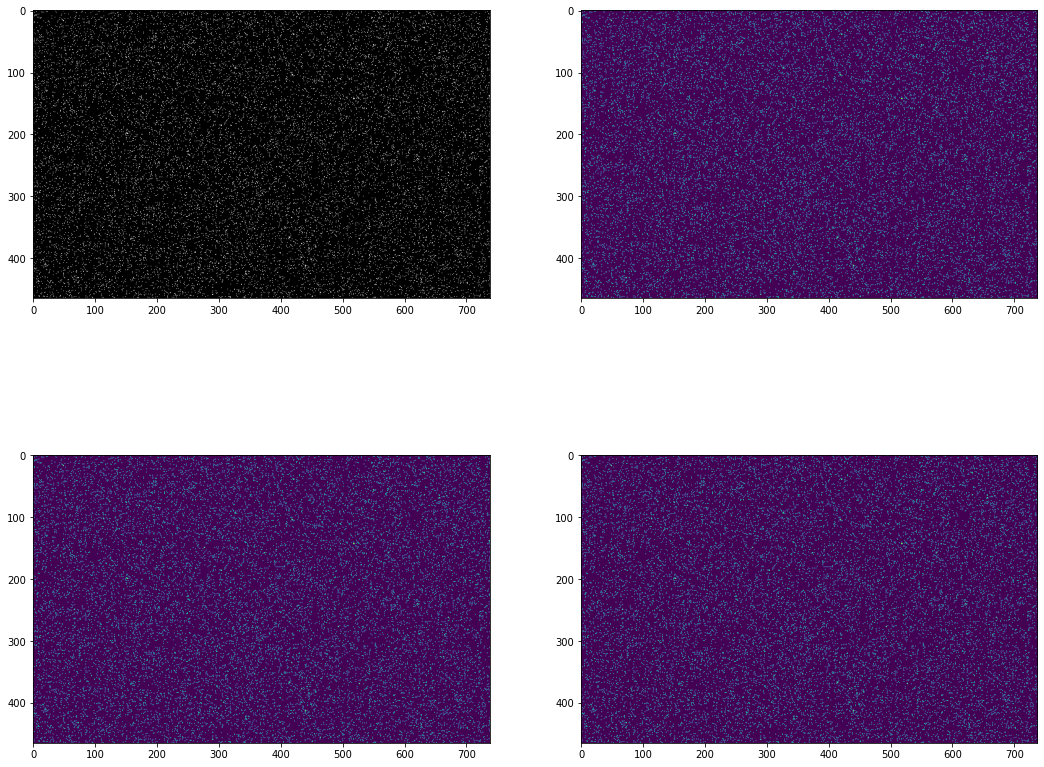

In [40]:
plt.figure(figsize = (20,20))
f, axarr = plt.subplots(2,2)
f.set_size_inches(18,15)
axarr[0,0].imshow(img)
axarr[1,0].imshow(gray)
axarr[0,1].imshow(filtered)
axarr[1,1].imshow(threshold)

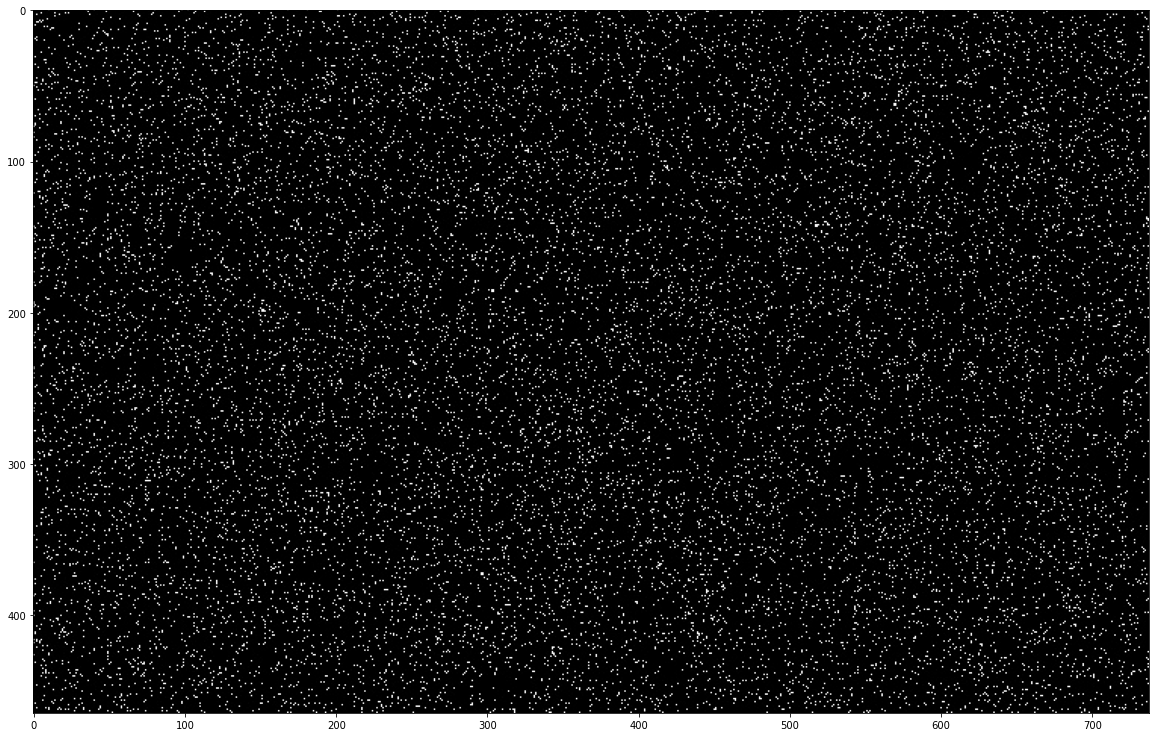

In [41]:
cv2.imwrite('otsu_processed_image.jpg', threshold)
img = cv2.imread("otsu_processed_image.jpg")
plt.figure(figsize = (20,20))
plt.imshow(img)

## Hough Circle Detection vs. Rectangle Detection Algorithm
Running on a small piece of the image.

(465, 738, 3)


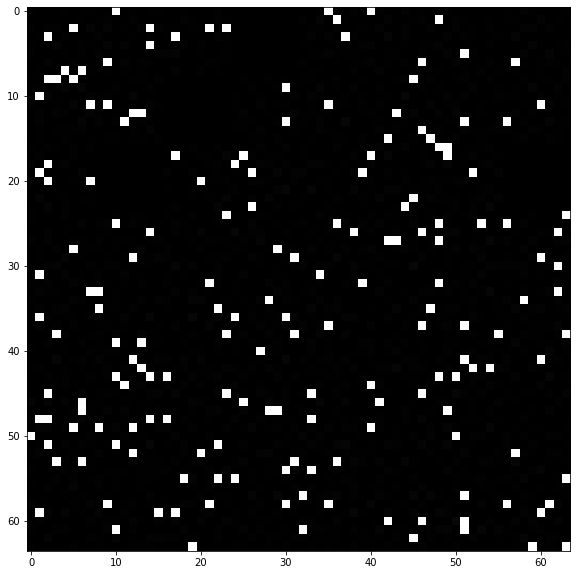

In [42]:
threshold_small = cv2.imread("otsu_processed_image.jpg")
print(np.shape(threshold_small))
threshold_small = threshold_small[:64, :64]
plt.figure(figsize=(10,10))
plt.imshow(threshold_small)

Number of circles detected: 0


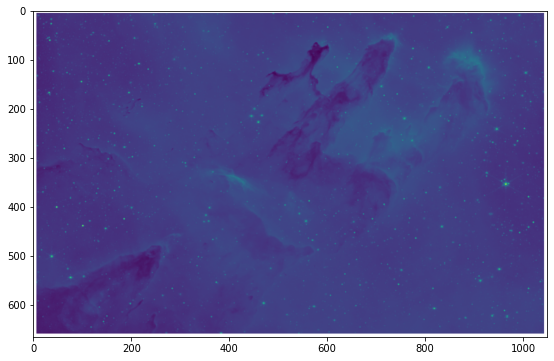

In [43]:
image = cv2.imread("LogNormInterpolated.png")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 5)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=1, maxRadius=0)

count = 0

if circles is not None:
    # Convert the circle parameters a, b and r to integers
    circles = np.round(circles[0, :]).astype("int")

    for (x, y, r) in circles:
        # Draw the circle in the output image, then draw a rectangle in the image
        # corresponding to the center of the circle
        cv2.circle(image, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(image, (x - 1, y - 1), (x + 1, y + 1), (0, 128, 255), -1)
        count += 1

print(f"Number of circles detected: {count}")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplots(figsize=(10, 6))
plt.imshow(image)
plt.show()

Unfortunately, this technique did not work on neither of the inputs (image and numpy array). Apparently, it is hard for the algorithm to detect circles in the image, or at least objects that resemble one.

## Rectangle Detection
Now, using the `findContours()` function in OpenCV, the number of edges, which corresponds to the total number of shapes, is going to be counted. 

For the purposes of checking the initial result, a smaller piece of the image has been selected; a $64 \times 64$ square to be exact.

Number of rectangles in the 64*64 square: 132


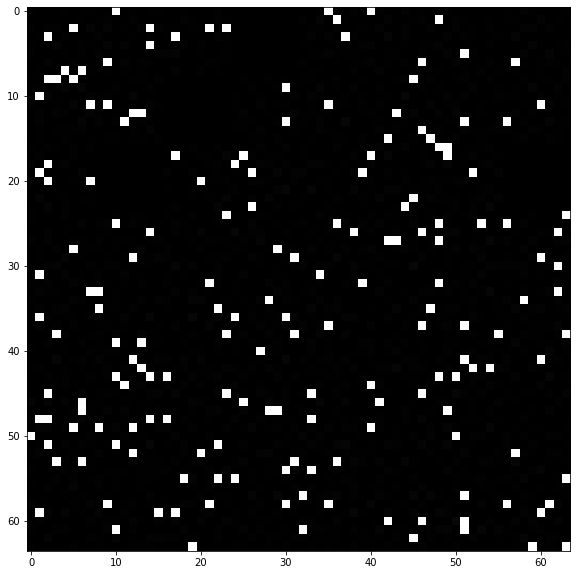

In [44]:
contours, _ = cv2.findContours(threshold[:64, :64], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.figure(figsize=(10,10))
plt.imshow(threshold_small)

counter = 0

for c in contours:
  epsilon = 0.1*cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, epsilon, True)
  if len(approx) == 1:
    counter += 1

print(f'Number of rectangles in the 64*64 square: {counter}')

Now counting the rectangles on the whole image:

Number of rectangles in the whole image: 10980


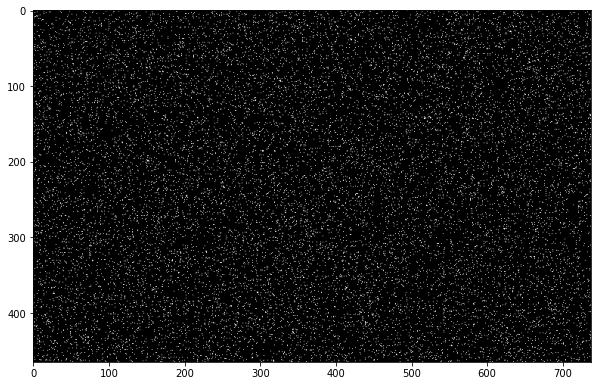

In [45]:
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.figure(figsize=(10,10))
plt.imshow(threshold, cmap="gray")

counter = 0

for c in contours:
  epsilon = 0.1*cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, epsilon, True)
  if len(approx) == 1:
    # Increment the counter
    counter += 1
print(f'Number of rectangles in the whole image: {counter}')

## Results
The results seem reasonable, since the average number of stars reported by manually counting such areas has only a $10 \%$ difference with the results reported. 

## On a Smaler Scale

Number of rectangles in the 64*64 square: 132


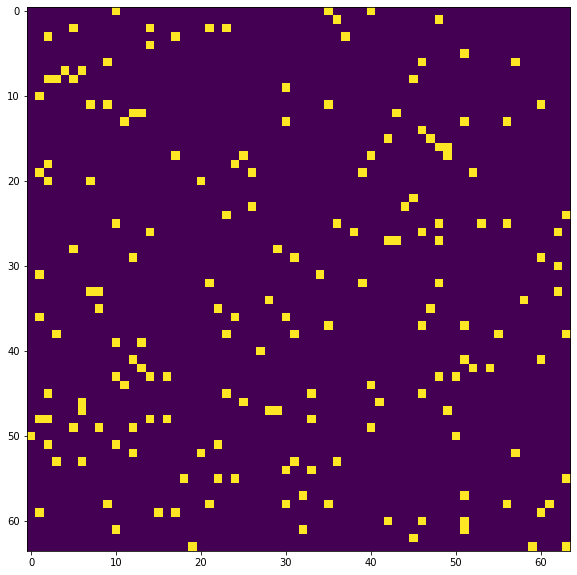

In [48]:
edges_small = threshold[:64, :64]

contours, _ = cv2.findContours(threshold[:64, :64], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.figure(figsize=(10,10))
plt.imshow(edges_small)

# Initialize a counter
counter = 0

# Loop over the contours
for c in contours:
    # Check if the contour is a rectangle
    # 0.6 gives a reasonable approximation
    epsilon = 0.1*cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, epsilon, True)
    if len(approx) == 1:
        # Increment the counter
        counter += 1

# Print the number of rectangles
print(f'Number of rectangles in the 64*64 square: {counter}')

Number of rectangles in the whole image: 13233


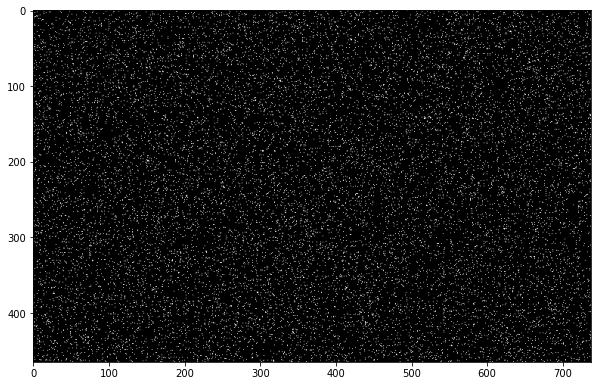

In [49]:
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.figure(figsize=(10,10))
plt.imshow(threshold, cmap="gray")

counter = 0

for c in contours:
    epsilon = 0.6*cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, epsilon, True)
    if len(approx) == 1:
        counter += 1

print(f'Number of rectangles in the whole image: {counter}')

## Applying Canny Edge Detection Algorithm

### On Original Image
This image has no filtering or blurring perfomed on it.

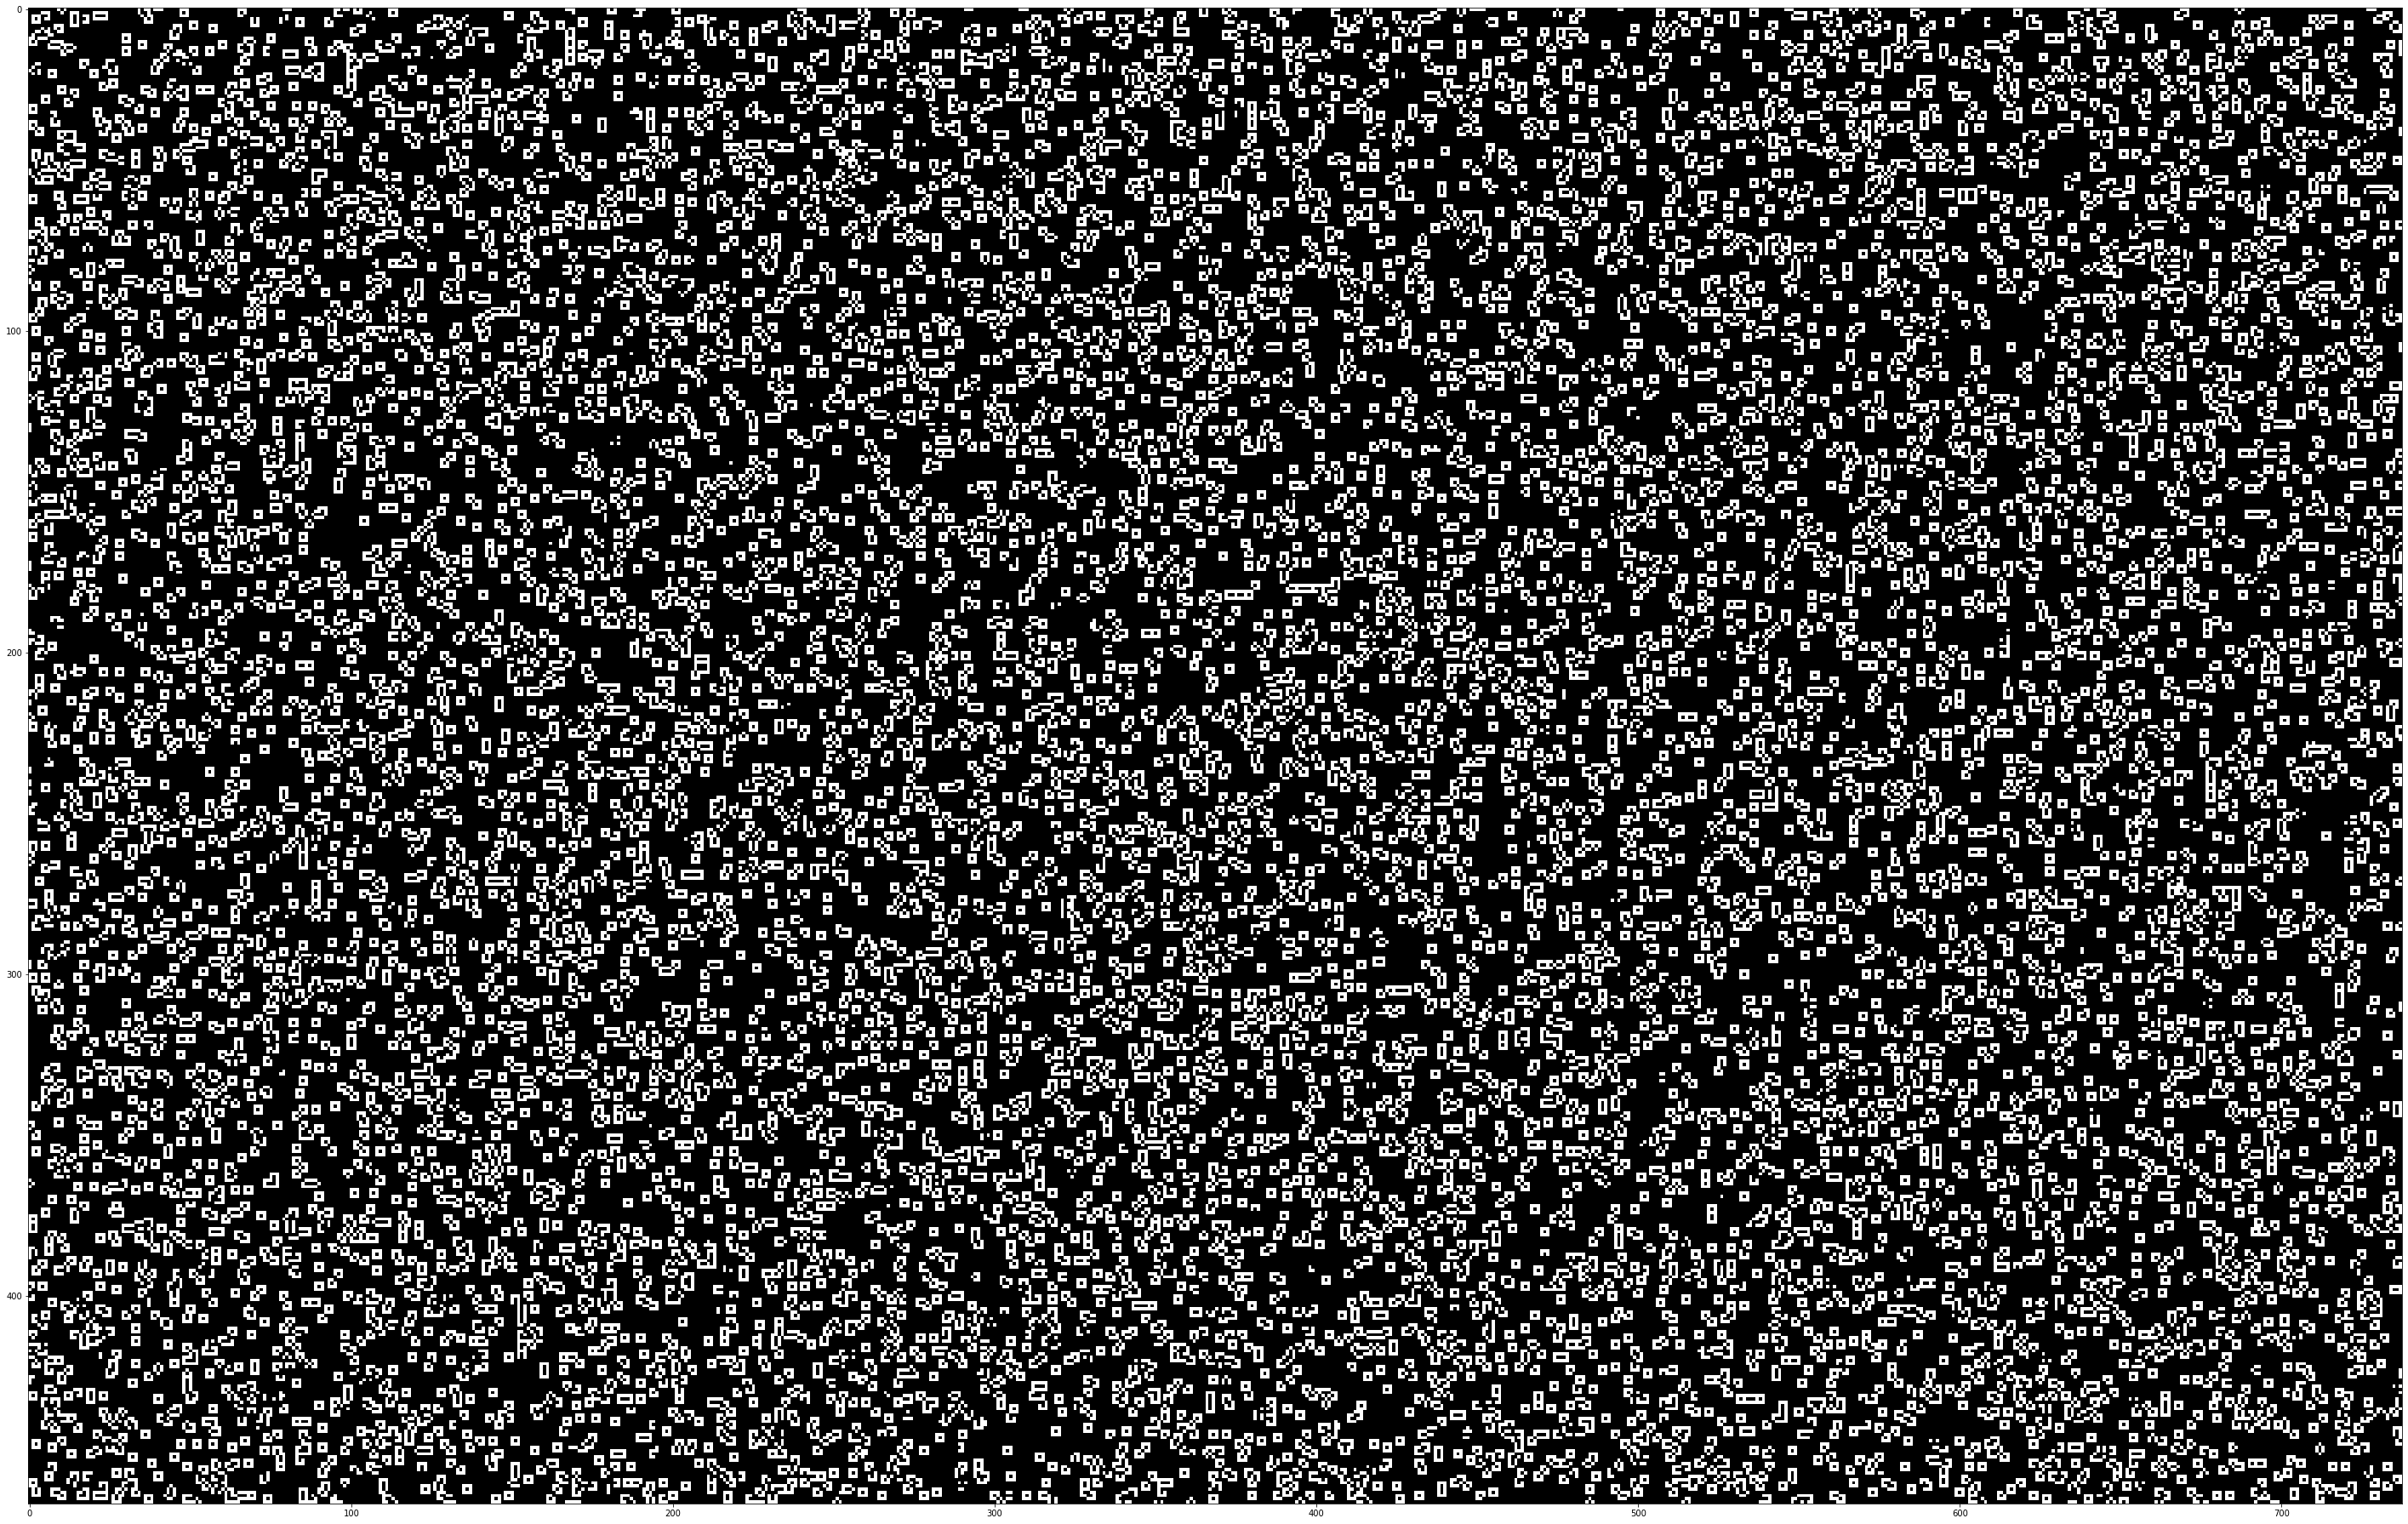

In [50]:
edges = cv2.Canny(img,100,200)

contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plt.figure(figsize = (50,50))
plt.imshow(edges, "gray")

In [51]:
results = []

for i in range(len(contours)):
    #initialize the parameters in e
    max_x = float('-inf')
    min_x = float('inf')
    max_y = float('-inf')
    min_y = float('inf')
    for j in range(len(contours[i])):
        x, y = contours[i][j][0]  # Unpack the X and Y values from the tuple
        max_x = max(max_x, x)  # Update the maximum X value if necessary
        min_x = min(min_x, x)  # Update the minimum X value if necessary
        max_y = max(max_y, y)  # Update the maximum Y value if necessary
        min_y = min(min_y, y)  # Update the minimum Y value if necessary
    results.append([min_x, max_x, min_y, max_y])

In [52]:
from astropy.io import fits

# Open the FITS file
hdulist = fits.open('m16_nircam.fits')

# Get the data from the file
data = hdulist[0].data

y_range, x_range = data.shape

intensity_list = []

for i in range(len(results)):
    intensity = 0
    for j in range(results[i][0], results[i][1]+1):
        for k in range(results[i][2], results[i][3]+1):
            intensity = data[k, j]
    intensity_list.append(intensity)

# Close the file
hdulist.close()

sorted_intensity = sorted(intensity_list, reverse=True)
print(sorted_intensity)

[2073.0303, 1947.0516, 993.31244, 896.9261, 867.33704, 696.64874, 637.522, 637.522, 588.0338, 588.0338, 511.66302, 493.9922, 441.63974, 419.2325, 381.71506, 374.23184, 372.46747, 349.38977, 325.0452, 325.0452, 318.903, 318.903, 315.1833, 314.62207, 305.10583, 292.75092, 292.75092, 291.52097, 290.93146, 290.93146, 282.3906, 282.3906, 248.68945, 237.56627, 220.54538, 216.24263, 210.78741, 210.78741, 210.43918, 210.43918, 209.12881, 208.08458, 204.43977, 202.35925, 198.1164, 191.19589, 190.65619, 190.65619, 182.7785, 172.072, 172.072, 171.65164, 167.79913, 167.79913, 157.72758, 157.70859, 155.93475, 153.50722, 152.69812, 152.05243, 150.58983, 149.57239, 148.55684, 148.55684, 148.01447, 147.90152, 147.81871, 147.81871, 143.43414, 143.43414, 142.16177, 141.67804, 139.56183, 139.56183, 138.6076, 138.53494, 138.53494, 138.49055, 137.22733, 135.27664, 135.27664, 131.87607, 131.37611, 130.42513, 130.40178, 127.79242, 127.67, 127.64301, 126.444954, 125.06946, 124.07125, 124.07125, 122.80304, 122

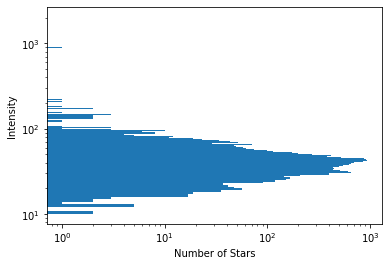

In [53]:
import matplotlib.pyplot as plt

min_num = int(min(intensity_list))
max_num = int(max(intensity_list))

# Create the histogram
plt.hist(intensity_list, range(min_num,max_num), orientation="horizontal")

plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.xlabel("Number of Stars")
plt.ylabel("Intensity")

# Show the plot
plt.show()

# Conclusion
As of now, the Canny algorithm (combined with the rectangle detection technique) reports a total number of $\approx 16,000$ stars. This number is roughly twice as much as what the Otsu approach reports. On paper, Canny's result seems mathematically correct, however, more experiments should be conducted.